## Null hypothesis: last 30 years the same temperature as before

Alternative: different temperature

Conclusion: reject null hypothesis

### Welch t-test

- wiki: https://en.wikipedia.org/wiki/Welch%27s_t-test
- scipy: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind

### Data source

- page: https://www.knmi.nl/nederland-nu/klimatologie/daggegevens/antieke-waarnemingen
- data: https://cdn.knmi.nl/knmi/map/page/klimatologie/gegevens/daggegevens/antieke_wrn/labrijn_ea.zip

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from scipy.stats import t

In [2]:
THRESHOLD = 1990

In [3]:
file_name = 'labrijn_ea.dat'
cols = 'year Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec Year  Win Spr Sum Aut'.split()
df = (
    pd.read_csv(file_name, sep=r'\s+', skiprows=21, header=0, names=cols)
    .set_index('year')
    .drop('Year Win Spr Sum Aut'.split(), axis=1)
    .dropna()  # drop incomplete last year (2021)
)
df['year_avg'] = df.mean(axis=1)
df[f'before_{THRESHOLD}'] = df.index < THRESHOLD
mask = df[f'before_{THRESHOLD}']
df.head()

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,year_avg,before_1990
year,,,,,,,,,,,,,,
1707,7,49,47,83,120,168.0,181.0,159.0,149.0,90.0,65.0,19.0,94.750000,True
1708,39,31,59,95,122,146.0,154.0,185.0,159.0,92.0,54.0,4.0,95.000000,True
1709,-51,-3,11,92,116,153.0,161.0,162.0,145.0,109.0,78.0,25.0,83.166667,True
1710,4,18,56,70,133,150.0,152.0,161.0,147.0,108.0,70.0,55.0,93.666667,True
1711,32,6,50,98,127,168.0,160.0,154.0,142.0,106.0,60.0,34.0,94.750000,True


In [4]:
assert 2020-1707+1 == df.shape[0]

<AxesSubplot:xlabel='year'>

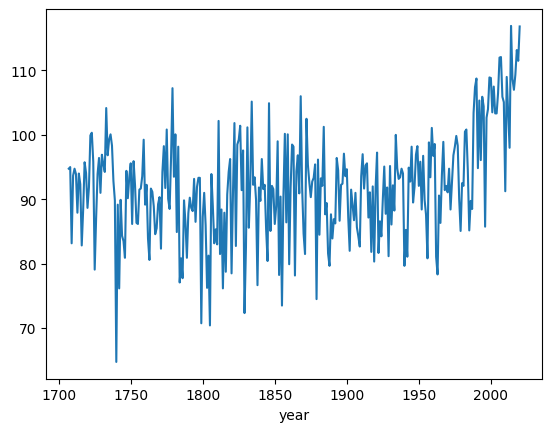

In [5]:
df['year_avg'].plot()

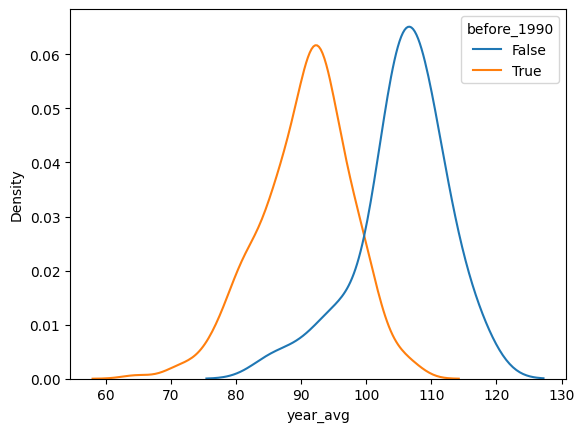

In [6]:
sns.kdeplot(data=df, x='year_avg', hue=f'before_{THRESHOLD}', common_norm=False)
plt.show()

In [7]:
before_1990 = df.loc[mask, 'year_avg']
from_1990 = df.loc[~mask, 'year_avg']

In [8]:
def std(x, dof):
    return (((x - x.mean()) ** 2).sum() / (x.shape[0] - dof)) ** 0.5

In [9]:
std(before_1990, dof=1), before_1990.std(ddof=1)

(7.004986535824251, 7.004986535824251)

In [10]:
# own implementation
mu1 = before_1990.mean()
mu2 = from_1990.mean()
sigma1 = before_1990.std(ddof=1)
sigma2 = from_1990.std(ddof=1)
n1 = before_1990.shape[0]
n2 = from_1990.shape[0]
std_error1 = sigma1 / np.sqrt(n1)
std_error2 = sigma2 / np.sqrt(n2)

test_stat = (mu1 - mu2) / (np.sqrt(std_error1 ** 2 + std_error2 ** 2))
dof = (std_error1 ** 2 + std_error2 ** 2) ** 2 / (std_error1 ** 4 / (n1 - 1) + std_error2 ** 4 / (n2 - 1))
pval = t.cdf(test_stat, df=dof) * 2

test_stat, dof, pval

(-11.510212643389224, 37.26574563278072, 7.840663626690791e-14)

In [11]:
# scipy implementation
scipy.stats.ttest_ind(before_1990, from_1990, equal_var=False)

Ttest_indResult(statistic=-11.510212643389224, pvalue=7.840663626690791e-14)

## 2nd null hypothesis: last 30 years are warmer than before

Cannot be rejected

In [12]:
scipy.stats.ttest_ind(before_1990, from_1990, equal_var=False, alternative='greater')

Ttest_indResult(statistic=-11.510212643389224, pvalue=0.9999999999999608)